# Pipeline for the Ilastik API, here we use bees.ipl (3 labels, all features)

In [59]:
import h5py
import matplotlib.pyplot as plt
import cv2
from skimage.morphology import disk, opening, closing
import numpy as np
import time

In [72]:
img = cv2.imread('img_cyril.jpg', cv2.IMREAD_UNCHANGED)
print(img.shape)
cv2.imwrite('img_cyril_gray.jpg', cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
img_gray = cv2.imread('img_cyril_gray.jpg', cv2.IMREAD_UNCHANGED)
print(img_gray.shape)

(2592, 4608, 3)
(2592, 4608)


In [73]:
ILASTIK_PATH = '/Users/fabianprofeta/Desktop/ilastik-1.4.0.post1-OSX.app/Contents/ilastik-release/run_ilastik.sh'
MODEL='train_on_cyril.ilp'
OUTPUT_FOLDER = './imgs_samples_mask/{nickname}_mask.png'
img = 'img_cyril_gray.jpg'
cv2.imwrite('img_cyril_gray_resized.jpg', cv2.resize(cv2.imread(img), (0,0), fx=0.5, fy=0.5))
IMG = 'img_cyril_gray_resized.jpg'
time_start = time.time()
!$ILASTIK_PATH  --headless --project=$MODEL $IMG
print('Time elapsed:', time.time()-time_start, 's')

INFO ilastik.app: Using tiktorch executable: ['/Users/fabianprofeta/Desktop/ilastik-1.4.0.post1-OSX.app/Contents/ilastik-release/bin/python', '-m', 'tiktorch.server']
INFO ilastik.app: config file location: <none>
INFO ilastik.app: Starting ilastik from "/Users/fabianprofeta/Desktop/ilastik-1.4.0.post1-OSX.app/Contents/ilastik-release/lib/python3.7".
Starting ilastik from "/Users/fabianprofeta/Desktop/ilastik-1.4.0.post1-OSX.app/Contents/ilastik-release/lib/python3.7".
WARNING 2024-04-16 13:53:27,864 opConservationTracking 7473 4600948224 Could not find any ILP solver
WARNING 2024-04-16 13:53:27,916 opStructuredTracking 7473 4600948224 Could not find any ILP solver
WARNING 2024-04-16 13:53:27,921 structuredTrackingWorkflow 7473 4600948224 Could not find any learning solver. Tracking will use flow-based solver (DPCT). Learning for tracking will be disabled!
INFO ilastik.shell.projectManager: Opening Project: train_on_cyril.ilp
INFO ilastik.workflows.pixelClassification.pixelClassificati

In [74]:
filename = "img_cyril_gray_resized_Probabilities.h5"
with h5py.File(filename, "r") as f:
    a_group_key = list(f.keys())[0]
    data = list(f[a_group_key])
    ds_arr = f[a_group_key][:,:,0]  # returns as a numpy array
    print(ds_arr)

[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.97 0.97 0.96]
 [0.   0.   0.   ... 0.97 0.98 0.96]
 [0.   0.   0.   ... 0.97 0.97 0.95]]


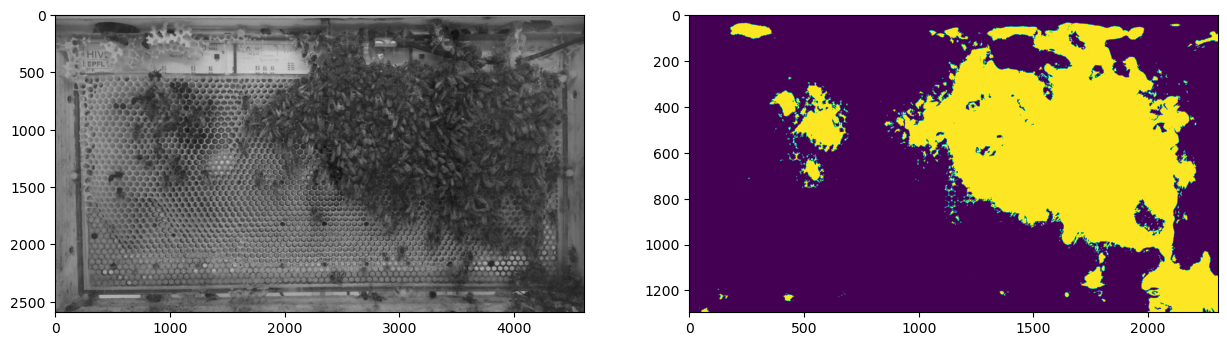

In [76]:
cv2.imwrite('img_cyril_gray_resized_Probabilities.png', ds_arr)
mask = cv2.imread('img_cyril_gray_resized_Probabilities.png', cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(cv2.imread('img_cyril_gray.jpg'), cmap='gray')
ax[1].imshow(mask)
plt.show()

In [77]:
# morphology
mask_open = opening(mask, disk(9))
mask_closed = closing(mask_open, disk(9))

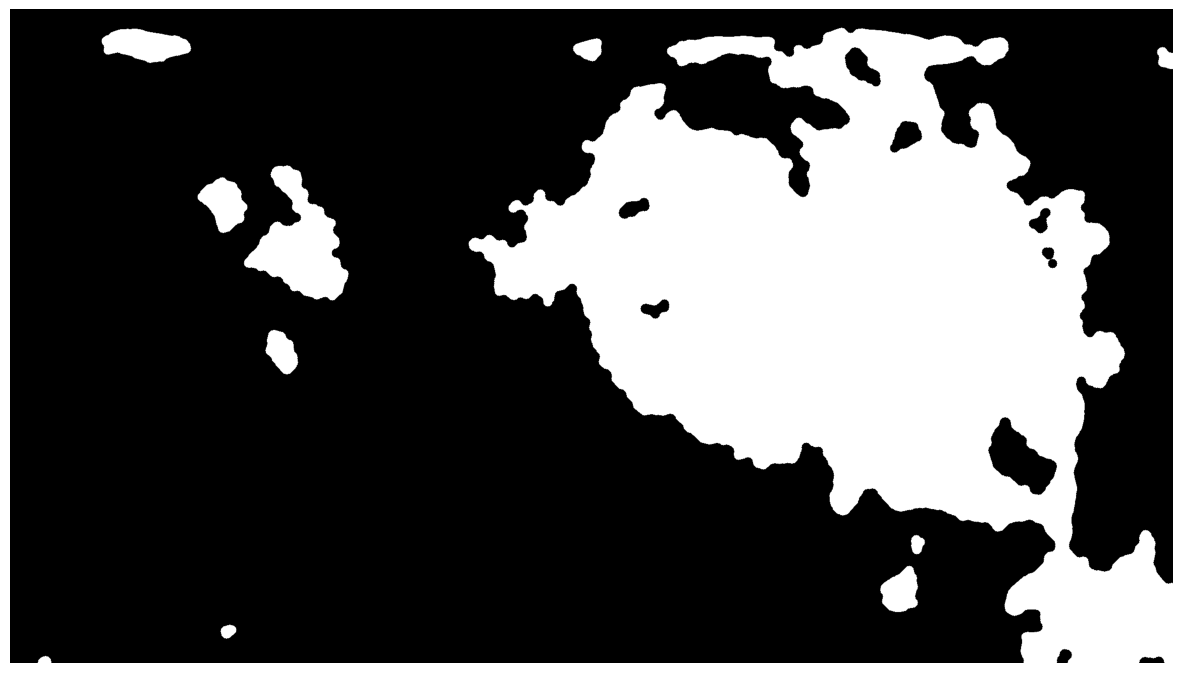

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(mask_closed, cmap='gray')
ax.axis('off')
# ax.set_title('Random Forest Classifier - Mask after morphological operations')
plt.show()

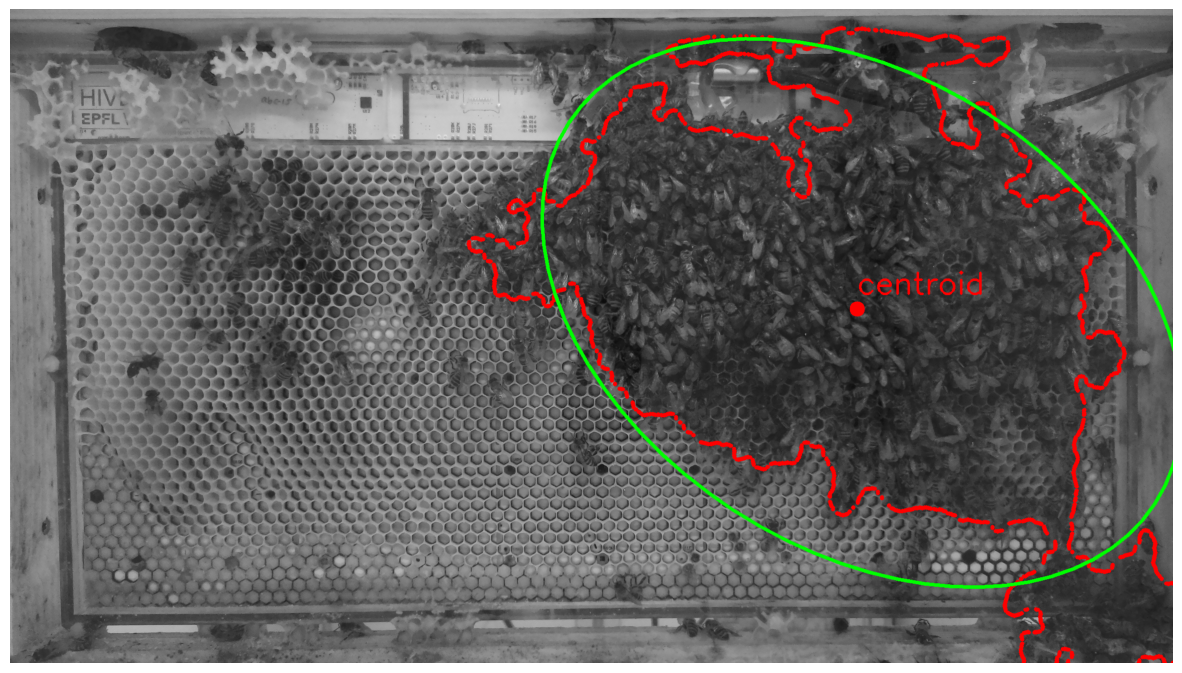

(2890, 1, 2)


In [79]:
input_image = cv2.resize(cv2.imread('img_cyril_gray.jpg'), (0,0), fx=0.5, fy=0.5)

# now we can find the contours

img_contour = (mask_closed).astype(np.uint8) #convert to uint8 because findContours only accepts uint8
contours, _ = cv2.findContours(img_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #find contours
contour = max(contours, key=cv2.contourArea) #get the biggest contour
img_contour = cv2.cvtColor(img_contour, cv2.COLOR_GRAY2BGR) #convert to BGR because drawContours only accepts BGR
cv2.drawContours(input_image, contour, -1, (255, 0, 0), 7) #draw the biggest contour

# find the centroid of the contour
M = cv2.moments(contour)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
# plot it on the image
cv2.circle(input_image, (cX, cY), 15, (255, 0, 0), -1)
cv2.putText(input_image, "centroid", (cX, cY - 30), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 4);

ellipse = cv2.fitEllipse(contour)
cv2.ellipse(input_image, ellipse, color=(0,255,0), thickness=5)
# print(ellipse[1][0]/ellipse[1][1])
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(input_image, cmap='gray')
ax.axis('off')
# ax.set_title('Random Forest Classifier - Centroid, Contour and best fitted Ellipse')
plt.show()
print(contour.shape)

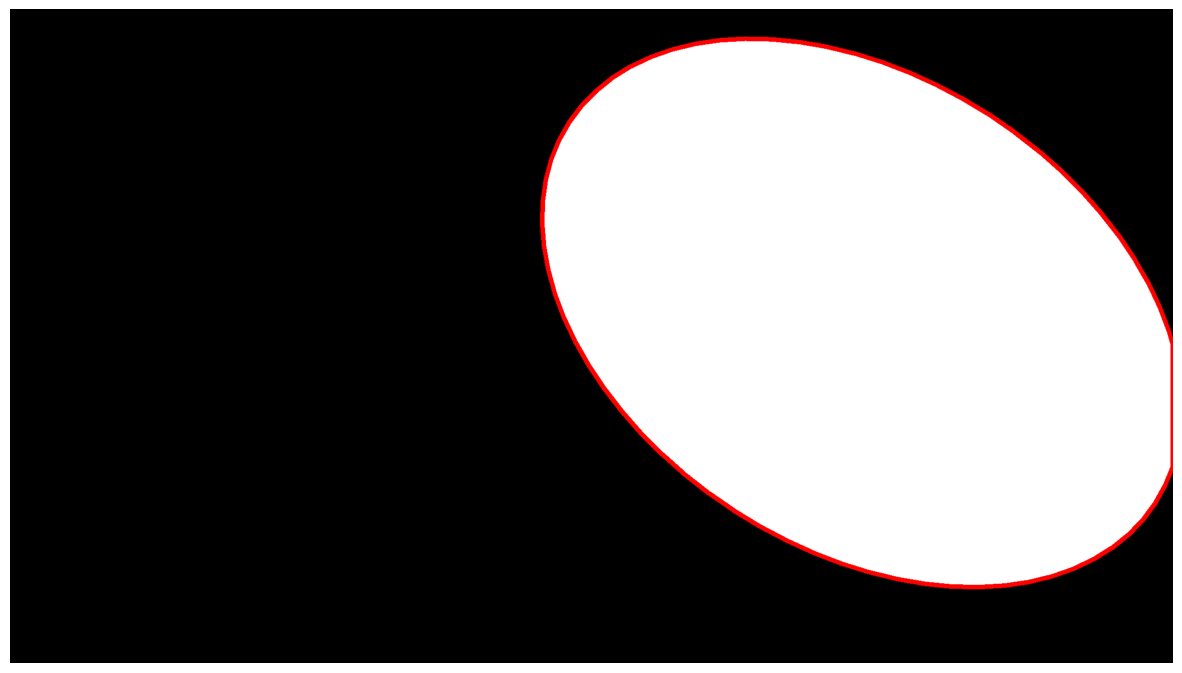

(1601, 1, 2)


In [80]:
# make a mask consited of the ellipse
mask_ellipse = np.zeros_like(mask_closed)
cv2.ellipse(mask_ellipse, ellipse, color=(255,255,255), thickness=-1)
ellipse_contours, _ = cv2.findContours(mask_ellipse, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #find contours
ellipse_contour = max(ellipse_contours, key=cv2.contourArea) #get the biggest contour
mask_ellipse = cv2.cvtColor(mask_ellipse, cv2.COLOR_GRAY2BGR) #convert to BGR because drawContours only accepts BGR
cv2.drawContours(mask_ellipse, ellipse_contours, -1, (255, 0, 0), 7) #draw the biggest contour
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(mask_ellipse, cmap='gray')
ax.axis('off')
# ax.set_title('Random Forest Classifier - Mask of the fitted ellipse')
plt.show()
print(ellipse_contour.shape)

(2890, 2) (1601, 2)
1289
(1601, 2) (1601, 2)


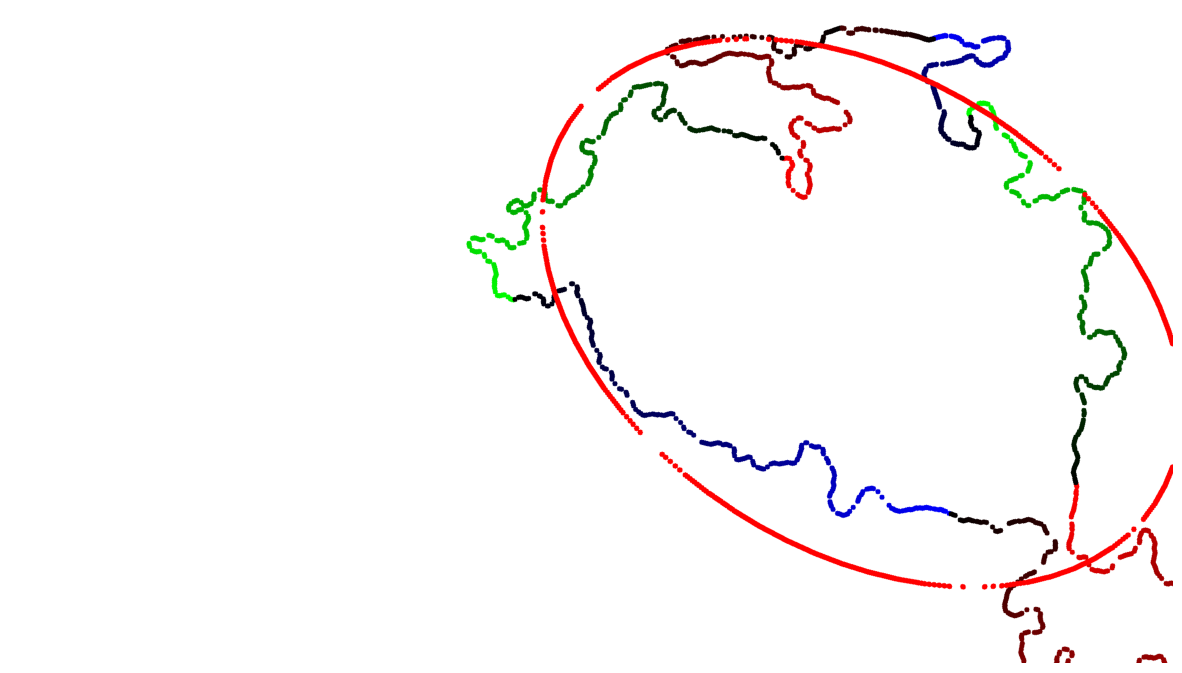

In [81]:
contour_points = contour.reshape(-1, 2)
ellipse_points = ellipse_contour.reshape(-1, 2)
print(contour_points.shape, ellipse_points.shape)
shape_diff = contour_points.shape[0] - ellipse_points.shape[0]
print(shape_diff)
new_contour = []
i = 1
skipped = 0
printed = 0

if shape_diff > 0:
    for point in contour_points:
        if (i == int(contour_points.shape[0]/shape_diff)) & (skipped < shape_diff):
            skipped += 1
            i = 1
            continue
        new_contour.append([point[0], point[1]])
        printed += 1
        i += 1
if shape_diff < 0:
    for point in ellipse_points:
        if (i == int(ellipse_points.shape[0]/shape_diff)) & (skipped < shape_diff):
            skipped += 1
            i = 1
            continue
        new_contour.append([point[0], point[1]])
        printed += 1
        i += 1

new_contour = np.array(new_contour)        
print(new_contour.shape, ellipse_points.shape) 

# plotting related stuff
n = 0
color = [0, 0, 0]
chanel = 0
y_offset = 0
image = np.ones(mask_closed.shape + (3,), dtype=np.uint8) * 255
for point in new_contour:
    cv2.circle(image, (point[0], point[1] + y_offset), 5, color, -1)
    if n < 255:
        n += 1
    else:
        n = 1
        chanel = 0 if chanel == 2 else chanel + 1
        color = [0, 0, 0]
    color[chanel] = n
n = 0
color = [0, 0, 0]
chanel = 0
for point in ellipse_points:
    cv2.circle(image, (point[0], point[1] + y_offset), 5, [255, 0, 0], -1)
    if n < 255:
        n += 1
    else:
        n = 1
        chanel = 0 if chanel == 2 else chanel + 1
        color = [0, 0, 0]
    color[chanel] = n

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(image)
ax.axis('off')
plt.show()

In [82]:
from sklearn.metrics import r2_score

r2_score(np.array(new_contour), ellipse_contour.reshape(-1, 2))


0.7380405001374839